---
date: 2024-11-13
title: "SQL, Homomorphisms and Constraint Satisfaction Problems"
---

Database queries are a pretty surprisingly powerful tool that can solve seemingly intractable problems.

It is a fun coding challenge to do things in SQL. I've seen people solve sudokus or do [advent of code](https://github.com/mitchellh/advent-2021-sql), or you can build a datalog on SQL with a little metaprogramming (maybe even fully internally). It is also possible to build a CHR (constraint handling rules) system on SQL or a graph rewriting system on SQL. Here I talk about how one can use SQL queries to do graph instruction matching https://www.philipzucker.com/imatch-datalog/ .

SQL is a feature rich language, it is not surprising that you can do these things from that perspective, using this and that odd feature.

The core of SQL is basically "SELECT FROM WHERE" statements. These statements can be idealized in a couple different ways.
They are basically conjunctive queries https://en.wikipedia.org/wiki/Conjunctive_query#Relationship_to_other_query_languages . Each table is a logical predicate, each variable is bound to a row of a column. The SELECT fields are bits that aren't being existentially bound and therefore hidden, aka free variables.

$\exists y. edge(x,y) \land path(y,z)$ is the predicate form of the query ```SELECT edge.a, path.b from edge, path WHERE edge.b = path.a```. There is a little bit of rearrangement from the entry centric view of predicates to the row centric view of SQL. I amc not aware of a way to easily give a name to a particular entry in sql. I used this correspondence to describe how to either build a datalog engine on sql, or hand compile your datalog rules to sql https://www.philipzucker.com/tiny-sqlite-datalog/ . 

From a more imperative perspective, SELECT-FROM-WHERE statements are basically for loops. SQL is an odd language in that the FROM comes after the SELECT. This puts a row variables binding site after its binding point.

| SQL               | Python |
| `FROM mytable as row_a` | `for row_a in mytable:` |
| `WHERE row_a.col1 = rowa.col2` | `if row_a.col1 == row_a.col2:` |
| `SELECT row_a.col1, row_a.col2` | `yield row_a.col1, row_a.col2` |

A thing SQL engines do is that they rearrange and optimize these loops and refactor them into joins and other things. Python for loops however execute just like you say it (slowly).

Search problems can be solved by brute force loops. Enumerate all possibilities and take the ones that work.

So in this manner SQL is a constraint solver.

An example constraint satisfaction puzzle is the send more money puzzle https://en.wikipedia.org/wiki/Verbal_arithmetic in which we need to find digist such that `SEND + MORE = MONEY`.
A pure python version of the send more money puzzle is

In [ ]:
def solve_send_money():
    for s in range(1, 10):  # S must be non-zero
        for e in range(10):
            if e == s:
                continue
            for n in range(10):
                if n in (s, e):
                    continue
                for d in range(10):
                    if d in (s, e, n):
                        continue
                    for m in range(1, 10):  # M must be non-zero
                        if m in (s, e, n, d):
                            continue
                        for o in range(10):
                            if o in (s, e, n, d, m):
                                continue
                            for r in range(10):
                                if r in (s, e, n, d, m, o):
                                    continue
                                for y in range(10):
                                    if y in (s, e, n, d, m, o, r):
                                        continue
                                    # Convert SEND, MORE, and MONEY to integers
                                    send = 1000 * s + 100 * e + 10 * n + d
                                    more = 1000 * m + 100 * o + 10 * r + e
                                    money = 10000 * m + 1000 * o + 100 * n + 10 * e + y
                                    
                                    if send + more == money:
                                        return (s,e,n,d,m,o,r,e,m,o,n,e,y), send, more, money


In [7]:
%%timeit 
solve_send_money()

762 ms ± 35 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


We can write the same thing in SQL and execute using duckdb or sqlite. Duckdb is a bit faster and is faster than the pure python version.

In [61]:
import sqlite3
import duckdb
query = """
WITH RECURSIVE digits(digit) AS (
    SELECT 0
    UNION ALL
    SELECT digit + 1
    FROM digits
    WHERE digit < 9
)
SELECT s.digit AS S, e.digit AS E, n.digit AS N, d.digit AS D,
       m.digit AS M, o.digit AS O, r.digit AS R, y.digit AS Y
FROM digits s, digits e, digits n, digits d, digits m, digits o, digits r, digits y
WHERE s.digit <> e.digit AND s.digit <> n.digit AND s.digit <> d.digit AND s.digit <> m.digit AND
      s.digit <> o.digit AND s.digit <> r.digit AND s.digit <> y.digit AND
      e.digit <> n.digit AND e.digit <> d.digit AND e.digit <> m.digit AND
      e.digit <> o.digit AND e.digit <> r.digit AND e.digit <> y.digit AND
      n.digit <> d.digit AND n.digit <> m.digit AND n.digit <> o.digit AND
      n.digit <> r.digit AND n.digit <> y.digit AND
      d.digit <> m.digit AND d.digit <> o.digit AND d.digit <> r.digit AND
      d.digit <> y.digit AND
      m.digit <> o.digit AND m.digit <> r.digit AND m.digit <> y.digit AND
      o.digit <> r.digit AND o.digit <> y.digit AND
      r.digit <> y.digit AND
      s.digit <> 0 AND m.digit <> 0 AND
      (1000 * s.digit + 100 * e.digit + 10 * n.digit + d.digit) +
      (1000 * m.digit + 100 * o.digit + 10 * r.digit + e.digit) =
      (10000 * m.digit + 1000 * o.digit + 100 * n.digit + 10 * e.digit + y.digit);
"""
conn = sqlite3.connect(":memory:")
conn.execute(query).fetchall()


[(9, 5, 6, 7, 1, 0, 8, 2)]

In [65]:
%%timeit
conn = sqlite3.connect(":memory:")
conn.execute(query).fetchone()

969 ms ± 74.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [67]:
%%timeit
conn = duckdb.connect() # not really a noticeable part of benchmark
conn.execute(query).fetchone()

240 ms ± 16.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


This does raise the question of comparing to a C version. Quite a bit faster indeed.

In [ ]:
%%file /tmp/money.c
#include <stdio.h>
#include <time.h>
int main() {
    clock_t start_time = clock();
    //int niter = 0; Adding this slows clang down quite a bit
    for (int s = 1; s < 10; s++) { // S must be non-zero
        for (int e = 0; e < 10; e++) {
            if (e == s) continue;
            for (int n = 0; n < 10; n++) {
                if (n == s || n == e) continue;
                for (int d = 0; d < 10; d++) {
                    if (d == s || d == e || d == n) continue;
                    for (int m = 1; m < 10; m++) { // M must be non-zero
                        if (m == s || m == e || m == n || m == d) continue;
                        for (int o = 0; o < 10; o++) {
                            if (o == s || o == e || o == n || o == d || o == m) continue;
                            for (int r = 0; r < 10; r++) {
                                if (r == s || r == e || r == n || r == d || r == m || r == o) continue;
                                for (int y = 0; y < 10; y++) {
                                    if (y == s || y == e || y == n || y == d || y == m || y == o || y == r) continue;

                                    // Calculate SEND, MORE, and MONEY
                                    int send = 1000 * s + 100 * e + 10 * n + d;
                                    int more = 1000 * m + 100 * o + 10 * r + e;
                                    int money = 10000 * m + 1000 * o + 100 * n + 10 * e + y;
                                    //niter++;

                                    if (send + more == money) {
                                        clock_t end_time = clock();
                                        double time_taken = ((double)(end_time - start_time)) / CLOCKS_PER_SEC;
                                        printf("Time taken by loops: %.6f seconds\n", time_taken);
                                        printf("SEND = %d, MORE = %d, MONEY = %d\n", send, more, money);
                                        //printf("Tests: %d\n", niter);
                                        return 0;
                                    }
                                }
                            }
                        }
                    }
                }
            }
        }
    }
    return 1;
}

Overwriting /tmp/money.c


In [84]:
! clang -O3 -march=native -o /tmp/money /tmp/money.c && /tmp/money

Time taken by loops: 0.003991 seconds
SEND = 9567, MORE = 1085, MONEY = 10652


In [85]:
! gcc -O3 -march=native -o /tmp/money /tmp/money.c && /tmp/money

Time taken by loops: 0.019185 seconds
SEND = 9567, MORE = 1085, MONEY = 10652


Hmm. My system clang vs gcc is another 5x? That's kind of surprising. I have a new clang (20) and an old gcc 11.4. Maybe that's enough. The thing also that it may be rearranging the loops? If I try to add a counter, clang slows down to about gcc. Very interesting.

# Relation and Graph Homomorphisms

There is another perspective on what SQL is doing. It is finding a mapping (a homomorphism) between the query and the database.

We have intuition about databases that comes from typically thinking about small queries (< 100 tables reference in FROM statements) and big databases (millions, billions or more of rows).

The running time of naive nested loops is exponential in the number of loops. Considered as a function of the size the of query, database queries are quite computationally expensive.

I have heard that I should be scared of subgraph matching or graph isomorphism because they are NP ish. But in many common cases, the size of the patterns is pretty small, and the size of the database is pretty big. So the problem is not that hard.

Graphs can be easily mapped into database tables as an edge table with two columns.

Here for example I can turn a networkx graph into a sqlite table

In [87]:
import sqlite3
import networkx as nx
def db_of_graph(conn, G):
    con.executemany("INSERT INTO nodes VALUES (?)", map(lambda v : (v,),  G.nodes))
    con.executemany("INSERT INTO edges VALUES (?, ?)", G.edges)
    if not G.is_directed():
        con.executemany("INSERT INTO edges VALUES (?, ?)", [(j,i) for i,j in G.edges])

And conversely export the edge table back out into a networkx graph.

In [88]:
def graph_of_db(con):
    G = nx.DiGraph()
    res = con.execute("SELECT * FROM nodes")
    G.add_nodes_from(map(lambda x: x[0], res.fetchall()))
    res = con.execute("SELECT * FROM edges")
    G.add_edges_from(res.fetchall())
    return G


The form of these simple `FROM-SELECT-WHERE` queries (conjuctive queries) is remarkably similar to a database itself.
In the Alice book http://webdam.inria.fr/Alice/ , I've seen this referred to as


In [91]:
def query_of_graph(G,unique=False):
    """Unique will give subgraph isomorphism"""
    selects = []
    froms = []
    wheres = []
    for node in G:
        froms += [f"nodes AS v{node}"]
        selects += [f"v{node}.v AS v{node}"]
    for i, (a,b) in enumerate(G.edges):
        froms += [f"edges as e{i}"]
        wheres += [f"e{i}.src = v{a}.v"  , f"e{i}.dst = v{b}.v"]
    if unique:
        for node in G:
            for node2 in G:
                if node != node2:
                    wheres += [f"v{node} != v{node2}"]
    sql = "SELECT " + ", ".join(selects) + \
          "\nFROM " +  ", ".join(froms) + \
          "\nWHERE " + " AND ".join(wheres)
    return sql
def clear_db(con):
    con.execute("DELETE FROM nodes")
    con.execute("DELETE FROM edges")
con = sqlite3.connect(":memory:")
con.execute("CREATE TABLE nodes(v)")
con.execute("CREATE TABLE edges(src,dst)")

We can make a graph and insert the appropriate edge table into the database.

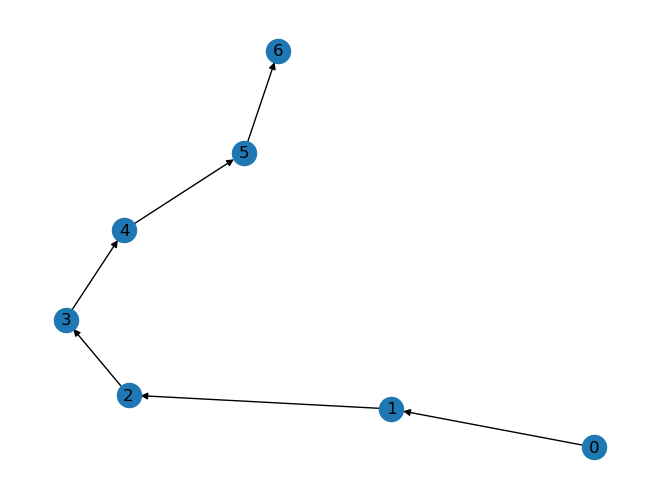

In [93]:
G = nx.path_graph(7, create_using=nx.DiGraph)
nx.draw(G, with_labels=True)

In [94]:
db_of_graph(con, G)
con.execute("SELECT * from edges").fetchall()

[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6)]

We can seek out the smaller pattern graph from the larger graph

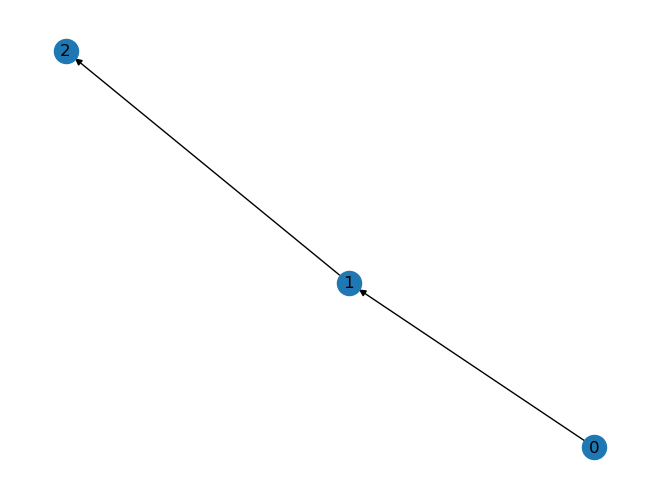

In [95]:
lhs = nx.path_graph(3, create_using=nx.DiGraph)
nx.draw(lhs, with_labels=True)

In [97]:
print(query_of_graph(lhs))

SELECT v0.v AS v0, v1.v AS v1, v2.v AS v2
FROM nodes AS v0, nodes AS v1, nodes AS v2, edges as e0, edges as e1
WHERE e0.src = v0.v AND e0.dst = v1.v AND e1.src = v1.v AND e1.dst = v2.v


In [ ]:
con.execute(query_of_graph(lhs)).fetchall()

[(0, 1, 2), (1, 2, 3), (2, 3, 4), (3, 4, 5), (4, 5, 6)]

We can also find all homomorphisms of the graph into itself, of which there is only one for the directed graph.

In [100]:
con.execute(query_of_graph(G)).fetchall()

[(0, 1, 2, 3, 4, 5, 6)]

For the undirected graph, there are more homomorphisms. 

In [102]:
clear_db(con)
G = nx.path_graph(4) # undirected
db_of_graph(con, G)
res = con.execute(query_of_graph(G))
res.fetchall()


[(1, 0, 1, 0),
 (1, 0, 1, 2),
 (0, 1, 0, 1),
 (0, 1, 2, 1),
 (0, 1, 2, 3),
 (2, 1, 0, 1),
 (2, 1, 2, 1),
 (2, 1, 2, 3),
 (1, 2, 1, 0),
 (1, 2, 1, 2),
 (1, 2, 3, 2),
 (3, 2, 1, 0),
 (3, 2, 1, 2),
 (3, 2, 3, 2),
 (2, 3, 2, 1),
 (2, 3, 2, 3)]

A homomorphism into yourself is not an isomorphism. You need a uniqueness constraint also for that, which can easily be expressed in SQL. The undirected path graph has 2 automorphisms, the identity and the reversal.

In [104]:
res = con.execute(query_of_graph(G,unique=True))
res.fetchall()

[(0, 1, 2, 3), (3, 2, 1, 0)]

We can also implement a coloring as an homomorphism into the fully connected graph, representing the colors and allowed edges between colors.

In [ ]:
clear_db(con)
colors = nx.complete_graph(2) # a two coloring graph
db_of_graph(con,colors)
res = con.execute("SELECT * FROM edges")
res = print(res.fetchall())

[(0, 1), (1, 0)]


In [108]:
res = con.execute(query_of_graph(G)) # two dimer colorings
print(res.fetchall())

[(1, 0, 1, 0), (0, 1, 0, 1)]


# Bits and Bobbles
https://dl.acm.org/doi/pdf/10.1145/335168.335209 Constraint Satisfaction and Database Theory: a Tutorial Moshe Y. Vardi

https://users.soe.ucsc.edu/~kolaitis/talks/csp-oxford.pdf  Constraint Satisfaction and Logic Phokion G. Kolaitis

https://berkeley-cs294-248.github.io/  CS294-248: Topics in Database Theory

Alice book http://webdam.inria.fr/Alice/ Foundations of Databases

https://www.youtube.com/watch?v=mykR7mP5Zdk&t=269s&ab_channel=SimonsInstitute  Logic and Databases Phokion Kolaitis

Query containment. Since you can make a sql query to find homomorphisms, you can check query containment as a sql query itself. Isn't that fun?

The symbolic database as a herbrand model.

Gra

I've never seriously used a graph database, but I kind of can't see the appeal for this reason. I find pretty often modelling domains as graphs to not actually map that well because I want a notion of ordering.

I really had this one rotting in my draft backlog for a long time. Good to just dump stuff out.

# SQL model check
SQL is a model checker for first order logic. SQL + something like NOT and EXISTS statements can express any first order logic statement.

Model checking has a connotation of being about temporal logic, or software system checking. But the term itself is talking about literally checking a model satisfies a formula `M |= t`. Model checking is a general concept that can be applied to any logic with a notion of smenantics.

Model checking is also kind of saying there is a kind of homomorphism between the syntax and semantics.

This is also a confusion that we have in talking about the "complexity" of a logic. The ocmplexity depends on which question we are asking. Are me asking satisfiability or model checking? Satisfiiability is also aasking about the `M |= t` models question, but it is of the form `formula -> option model` rather than the form `model -> formula -> bool`. The moding of the question is different.

When people talk about SAT being NP, they are talking about the satisfiability problem.
When they talk about existential second order logic being NP, they are talking about the model checking problem https://en.wikipedia.org/wiki/Fagin%27s_theorem https://en.wikipedia.org/wiki/Descriptive_complexity_theory

When people talk about datalog being PSPACE co





Tree decomposition for dynamic programming


## CSP


SQL queries are enumerating homomorphisms between the query and the database. This perspective puts the query and the database on smilar footing, which feels odd.

As a subcase of this capability, if the database is holding an edge table and attributes, then a query is a graph homomorphism solver.
If we dymmetrically place two graphs into the database and in a query, we can enumerate isomoprhisms. Isn't that fun?

Another perspective is that the query is a formula, and the database is a model of the formula.

We are used to small queries and large databases, but this is not a definition

A perspective on what a constraint satisfaction problem is is that is is a homomorphism problem.
For example, graph coloring is a homomorphism from a graph to a complete graph of colors (with no self edges).

Constraint satisfaction is an assignment to variables values frm their domain subject to constraints. The particular connectivty of a problem can be represented by a hypergraph. The target structure represents the domains the variables can take on, and the constraint hyperedges map to a relation representing the constraint.
A class of CSP problems is allowing the connecvtivity graph to vary, while keeping the target (the types of constraints fixed). Is this a useful characterization? Eh. It's interesting that it ties into other mathemtical topicas.

The naive solution of a constraint satsifaction problem is to just make a big sequence of loops, pruning / breaking with checks that constraint are satisifed. We want to push the checks as high as possible.
This a a very static perspective.
More dynammically, we want to pick the variable ordering inside the choice branches. This is more of a backtracking feel. We do proppagation to disallow subchoices

A problem that is easy to embed into database queries is graph homomomorphism. Queries and databases feel very different, but they are more symettric than you might think.

In typical usage, queries are small and databases are large.
A graph coloring problem can be mdelled as fnding a graph homomorphism into a complete graph. This flips the intuition on it's head with a large query and small database. Examples like these are better served probably by a constraint satisfaction solver or SAT style techniques.

The middle ground of roughly equal graphs is a graph isomorphism problem. Custom solvers like nauty exist for this case too.

```python
import sqlite3
import networkx as nx
def db_of_graph(conn, G):
    con.executemany("INSERT INTO nodes VALUES (?)", map(lambda v : (v,),  G.nodes))
    con.executemany("INSERT INTO edges VALUES (?, ?)", G.edges)
def graph_of_db(con):
    G = nx.DiGraph()
    res = con.execute("SELECT * FROM nodes")
    G.add_nodes_from(map(lambda x: x[0], res.fetchall()))
    res = con.execute("SELECT * FROM edges")
    G.add_edges_from(res.fetchall())
    return G
def query_of_graph(G):
    selects = []
    froms = []
    wheres = []
    for node in G:
        froms += [f"nodes AS v{node}"]
        selects += [f"v{node}.v AS v{node}"]
    for i, (a,b) in enumerate(G.edges):
        froms += [f"edges as e{i}"]
        wheres += [f"e{i}.src = v{a}.v"  , f"e{i}.dst = v{b}.v"]
    sql = "SELECT " + ", ".join(selects) + \
          "\nFROM " +  ", ".join(froms) + \
          "\nWHERE " + " AND ".join(wheres)
    return sql
G = nx.path_graph(7, create_using=nx.DiGraph)
lhs = nx.path_graph(3, create_using=nx.DiGraph)
con = sqlite3.connect(":memory:")

con.execute("CREATE TABLE nodes(v)")
con.execute("CREATE TABLE edges(src,dst)")
db_of_graph(con, G)
res = con.execute(query_of_graph(lhs))
print(res.fetchall())
# Result: [(0, 1, 2), (1, 2, 3), (2, 3, 4), (3, 4, 5), (4, 5, 6)]

print(graph_of_db(con))
"DELETE FROM nodes WHERE nodes.v = ?"
"DELETE FROM edges where edges.src = ? OR edges.dst = ?"

con.execute("DELETE FROM nodes")
con.execute("DELETE FROM edges")
colors = nx.complete_graph(2) # a two coloring
db_of_graph(con,colors)
# symmetrize. Maybe db_of_graph should do this. if not isinstanc(G,nx.DiGraph)
con.execute("INSERT INTO edges SELECT edges.dst, edges.src FROM edges")

res = con.execute("SELECT * FROM edges")
res = print(res.fetchall())
res = con.execute(query_of_graph(G))
print(res.fetchall())
# [(1, 0, 1, 0, 1, 0, 1), (0, 1, 0, 1, 0, 1, 0)]
```

Graph coloring can be solved through dynamic programming. If we cut up a graph, we only need to know if it can be colored with particular choices at interfaces. Choosing interfaces like this is a graph partitioning problem, but also is a tree decomposition.

One of the things that I found appealing about category theory is that it presents a design methodology to convert things that look graph-like like string diagrams into term-like expresssions of combinators.

Hmm. python-metis is not a thing anymore? Just pip install metis, it works with networkx anyway

```python
import metis

import networkx as nx
G = nx.path_graph(7)
edgecuts, parts = metis.part_graph(G,3)
print(edgecuts, parts)

print(nx.community.kernighan_lin_bisection(G)) # anneal a cut by node swapping
print(list(nx.community.girvan_newman(G))) # remove edges from graph
```

Recursively partition to build query plan (?)

You can build a query plan using these graph partitioners
but also query planners can be used to find partitions / tree decompositions.

There are also custom solvers for this.

graph datastructure

`[(v1,v2)]`

```
Node(outs,ins)
= [(outs,ins)]
out, inner , in

```

dynamic tree decomposition
hyprgraph data structure

```python
g1 = {(1,2), (2,3)}  # graph as set of (directed) edges
g2 = {{1,2}, {2,3}} #graph as sets of undirected edges

# ((multi)graph as map from named edges to src target vertices.
src = {"e1" : 1}
dst = {"e1" : 2}

{"e1": (1,2)}

# hypergraph as named edges
{"e1": {1,2,3}, "e2": {2,3,4}}

g = {{1,2,3}, {2,3,4}} # set of sets of vertices as hypergraph

#partition tree representation
g = ( [edges_between] , g1, g2  )

# rebalancing
```
